In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import torch.optim as optim
from sklearn.model_selection import train_test_split
import os
from skimage import io, transform
from utils import BengaliCharactersDataset
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import trange, tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
df_train_csv = pd.read_csv("train.csv")

X = df_train_csv.pop('image_id').to_frame()
df_train_csv.pop('grapheme')
y = df_train_csv

In [3]:
X_train, X_val, y_train, y_val = train_test_split(
        X, y,stratify=y, test_size=0.2)

data_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224,224)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.9469, 0.9469, 0.9469],
                             std=[0.1623, 0.1623, 0.1623]),
    ])

train_dataset = BengaliCharactersDataset(data=(X_train, y_train), root_dir='data/entire_dataset/', transform = data_transform)
val_dataset = BengaliCharactersDataset(data=(X_val, y_val), root_dir='data/entire_dataset/', transform = data_transform)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=10)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=10)


In [4]:
def calc_dataset_loss(data_loader):
    total = 0

    correct_grapheme = 0

    correct_vowel = 0

    correct_consonant = 0
    
    predictions_grapheme = []
    predictions_vowel = []
    predictions_consonant = []
    
    actual_grapheme = []
    actual_vowel = []
    actual_consonant = []

    for i in data_loader:
        CustomNet.eval()
        optimizer.zero_grad()
        test_out = CustomNet(i['image'].to(device))

        predicted_grapheme  = torch.argmax(test_out[0], dim=1)
        predictions_grapheme.append(predicted_grapheme)
        labels_grapheme = i['components'][:,:,0].squeeze().to(device)
        actual_grapheme.append(labels_grapheme)
        correct_grapheme += (predicted_grapheme  == labels_grapheme).sum().item()

        predicted_vowel = torch.argmax(test_out[1], dim=1)
        predictions_vowel.append(predicted_vowel)
        labels_vowel = i['components'][:,:,1].squeeze().to(device)
        actual_vowel.append(labels_vowel)
        correct_vowel += (predicted_vowel == labels_vowel).sum().item()

        predicted_consonant = torch.argmax(test_out[2], dim=1)
        predictions_consonant.append(predicted_consonant)
        labels_consonant = i['components'][:,:,2].squeeze().to(device)
        actual_consonant.append(labels_consonant)
        correct_consonant += (predicted_consonant == labels_consonant).sum().item()
        
        total += labels_consonant.shape[0]


    return {
            "grapheme_acc": correct_grapheme/total*100, 
            "vowel_acc":correct_vowel/total*100, 
            "consonant_acc":correct_consonant/total*100,
            "predictions_grapheme":torch.cat(predictions_grapheme),
            "predictions_vowel":torch.cat(predictions_vowel),
            "predictions_consonant":torch.cat(predictions_consonant),
            "actual_grapheme":torch.cat(actual_grapheme),
            "actual_vowel":torch.cat(actual_vowel),
            "actual_consonant":torch.cat(actual_consonant),
           }

In [5]:
class AppendNet(nn.Module):
    def __init__(self):
        super(AppendNet, self).__init__()
        self.start = nn.Linear(1000, 1000)
        self.fc_root = nn.Linear(1000, 168)
        self.fc_vowel = nn.Linear(1000, 11)
        self.fc_consonant = nn.Linear(1000, 7)
    
    def forward(self, x):
        root_prob = self.fc_root(F.relu(self.start(x)))
        vowel_prob = self.fc_vowel(F.relu(self.start(x)))
        consonant_prob = self.fc_consonant(F.relu(self.start(x)))
        return root_prob, vowel_prob, consonant_prob

vgg = models.vgg11(True)

In [6]:
CustomNet = nn.Sequential(vgg, AppendNet()).to(device)

criterion = nn.CrossEntropyLoss()


loss1_list = []
loss2_list = []
loss3_list = []
cnt=0

params_to_update = []
for name,param in CustomNet.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

In [8]:
optimizer = optim.Adam(params_to_update, lr=5e-4, amsgrad=True)

print("Training accuracy:")
train_stats = calc_dataset_loss(train_dataloader)
print("Grapheme:", train_stats['grapheme_acc'], "Vowel:", train_stats['vowel_acc'], "Consonant:", train_stats['consonant_acc'])
print("Validation accuracy:")
val_stats = calc_dataset_loss(val_dataloader)
print("Grapheme:", val_stats['grapheme_acc'], "Vowel:", val_stats['vowel_acc'], "Consonant:", val_stats['consonant_acc'])

Training accuracy:
Grapheme: 0.5881547500497909 Vowel: 18.253958374825732 Consonant: 8.681039633539136
Validation accuracy:
Grapheme: 0.5028878709420435 Vowel: 18.238398725353516 Consonant: 8.725851424019119


In [9]:
train_grapheme = []
train_vowel = []
train_consonant = []

val_grapheme = []
val_vowel = []
val_consonant = []

In [10]:
for epoch in tqdm(range(15), desc='Epochs'):
    running_loss1 = 0
    running_loss2 = 0
    running_loss3 = 0
    for i in tqdm(train_dataloader, desc='DataLoader'):
        CustomNet.train()
        cnt+=1
        optimizer.zero_grad()
        test_out = CustomNet(i['image'].to(device))
        loss1 = criterion(test_out[0], i['components'][:,:,0].squeeze(1).to(device))
        loss2 = criterion(test_out[1], i['components'][:,:,1].squeeze(1).to(device))
        loss3 = criterion(test_out[2], i['components'][:,:,2].squeeze(1).to(device))

        loss1_list.append(loss1.item())
        loss2_list.append(loss2.item())
        loss3_list.append(loss3.item())

        running_loss1+=loss1.item()
        running_loss2+=loss2.item()
        running_loss3+=loss3.item()

        loss1.backward(retain_graph=True)
        loss2.backward(retain_graph=True)
        loss3.backward()

        optimizer.step()

    train_stats = calc_dataset_loss(train_dataloader)
    train_grapheme.append(train_stats['grapheme_acc'])
    train_vowel.append(train_stats['vowel_acc'])
    train_consonant.append(train_stats['consonant_acc'])
    
    val_stats = calc_dataset_loss(val_dataloader)
    val_grapheme.append(val_stats['grapheme_acc'])
    val_vowel.append(val_stats['vowel_acc'])
    val_consonant.append(val_stats['consonant_acc'])

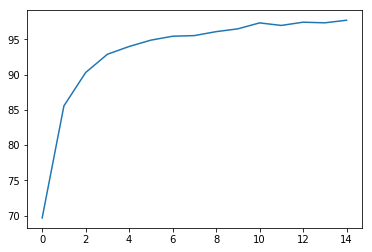

In [11]:
plt.plot(train_grapheme)

In [12]:
val_stats = calc_dataset_loss(val_dataloader)

In [13]:
print(val_stats['predictions_grapheme'].shape, val_stats['actual_grapheme'].shape)

torch.Size([40168]) torch.Size([40168])


In [14]:
from sklearn.metrics import confusion_matrix

In [31]:
grapheme_cf = confusion_matrix(val_stats['actual_grapheme'].cpu().numpy(), val_stats['predictions_grapheme'].cpu().numpy())
grapheme_cf = grapheme_cf.astype('float') / grapheme_cf.sum(axis=1)[:, np.newaxis]
print(grapheme_cf.diagonal())

[0.96551724 0.93103448 0.94117647 0.84375    0.94029851 1.
 0.91803279 0.74193548 0.77419355 0.93258427 0.83333333 0.73333333
 0.93103448 0.95124195 0.91875    0.94009217 0.95238095 0.96052632
 0.89939024 0.82142857 0.88059701 0.94680851 0.89544688 0.94157741
 0.92537313 0.88888889 0.91176471 0.95081967 0.90066225 0.87971275
 0.86206897 0.79605263 0.72687225 0.81481481 0.89090909 0.88421053
 0.92718447 0.8245614  0.95081967 0.94308943 0.94039735 0.95081967
 0.92091837 0.92955801 0.93364929 0.86206897 0.76724138 0.89010989
 0.92753623 0.953125   0.93197279 0.89230769 0.88770053 0.89566396
 0.76470588 0.93175074 0.91465677 0.88976378 0.91860465 0.85074627
 0.71428571 0.65217391 0.67241379 0.86666667 0.94012511 0.90842491
 0.96855346 0.91578947 0.81889764 0.88815789 0.90104167 0.96928328
 0.95470383 0.84615385 0.98688525 0.95111111 0.89119171 0.93193717
 0.86440678 0.90882779 0.88888889 0.89259797 0.82758621 0.84859155
 0.59340659 0.76642336 0.9354067  0.85294118 0.91447368 0.96336207
 0.

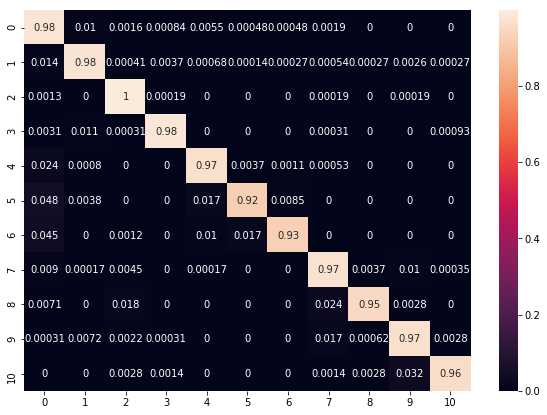

In [23]:
vowel_cf = confusion_matrix(val_stats['actual_vowel'].cpu().numpy(), val_stats['predictions_vowel'].cpu().numpy())
vowel_cf = vowel_cf.astype('float') / vowel_cf.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(vowel_cf, range(vowel_cf.shape[0]), range(vowel_cf.shape[0]))
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)# font size
plt.show()

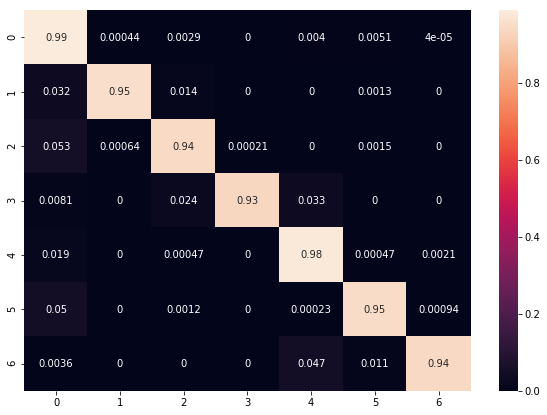

In [21]:
consonant_cf = confusion_matrix(val_stats['actual_consonant'].cpu().numpy(), val_stats['predictions_consonant'].cpu().numpy())
consonant_cf = consonant_cf.astype('float') / consonant_cf.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(consonant_cf, range(consonant_cf.shape[0]), range(consonant_cf.shape[0]))
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)# font size
plt.show()